In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
x_l = np.load('input/Sign-language-digits-dataset/X.npy')
Y_l = np.load('input/Sign-language-digits-dataset/Y.npy')
img_size = 64

X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0)
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])

x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T

In [14]:
def initialize_weights_and_bias(dimension, w_init = 0.01, b_init = 0.0):
    w = np.full((dimension,1),w_init)
    b = b_init
    return w, b


def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head


def vector_with_truncated_mantissa(values, mantissa_bits):
    """
    Truncate the mantissa to a specified number of bits for each entry in a vector.
    
    Args:
        values (numpy array): Input array of floating-point numbers.
        mantissa_bits (int): Number of bits to keep in the mantissa.
    
    Returns:
        numpy array: Array with values approximated using the truncated mantissa.
    """
    signs = np.sign(values)
    abs_values = np.abs(values)
    exponents = np.floor(np.log2(abs_values))
    mantissas = abs_values / (2 ** exponents)
    
    fractional_parts = mantissas - 1
    truncated_fractional = np.floor(fractional_parts * (2 ** mantissa_bits)) / (2 ** mantissa_bits)
    truncated_mantissas = 1 + truncated_fractional
    
    approximate_values = signs * truncated_mantissas * (2 ** exponents)
    return approximate_values


def forward_propagation(w,b,x_train,y_train):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    
    return cost 


def forward_backward_propagation(w,b,x_train,y_train, delta = 0.0, number_of_bits = -1):
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]      # x_train.shape[1]  is for scaling
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] # x_train.shape[1]  is for scaling
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]                 # x_train.shape[1]  is for scaling
    if delta != 0:
        if number_of_bits == 'worst':
            randomness_w = -(cost - cost_optimal)/(w - w_optimal.reshape(w.shape))
        else:
            randomness_w = np.random.uniform(-100, 100, size=np.shape(derivative_weight))
        randomness_w /= np.linalg.norm(randomness_w)
        derivative_weight_2 = randomness_w * np.linalg.norm(derivative_weight) * delta + derivative_weight
        derivative_bias_2 = (1+delta)*derivative_bias
        gradients = {"derivative_weight": derivative_weight_2,"derivative_bias": derivative_bias_2}
    else:
        if number_of_bits == -1 or number_of_bits == 'worst':
            gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
        else: 
            derivative_weight_2 = vector_with_truncated_mantissa(derivative_weight, number_of_bits)
            derivative_bias_2 = vector_with_truncated_mantissa(derivative_bias, number_of_bits)
            gradients = {"derivative_weight": derivative_weight_2,"derivative_bias": derivative_bias_2}
    ratio = 0
    return cost, gradients, ratio


def update(w, b, x_train, y_train, x_test, y_test, learning_rate, number_of_iterations, delta = 0.0, momentum = 0.9, list_step = False, number_of_bits=-1):
    para_list = [np.concatenate((w.reshape(-1),[b]))]
    cost_list2 = []
    training_accuracy = []
    test_accuracy = []
    index = []
    gradient_list = []

    w_y = np.copy(w)
    b_y = b

    for i in range(number_of_iterations):
        if list_step:
            cost, gradients, ratio = forward_backward_propagation(w, b, x_train, y_train, delta, number_of_bits)
            w = w - learning_rate[i] * gradients["derivative_weight"]
            b = b - learning_rate[i] * gradients["derivative_bias"]
        else:
            if momentum != 0.0:
                w_old = np.copy(w)
                b_old = b

                cost, gradients, ratio = forward_backward_propagation(w_y, b_y, x_train, y_train, delta, number_of_bits)
                w = w_y - learning_rate * gradients['derivative_weight']
                b = b_y - learning_rate * gradients['derivative_bias']

                t = i / (i + 3)
                w_y = w + t * (w - w_old)
                b_y = b + t * (b - b_old)

            else:
                cost, gradients, ratio = forward_backward_propagation(w, b, x_train, y_train, delta, number_of_bits)
                w = w - learning_rate * gradients['derivative_weight']
                b = b - learning_rate * gradients['derivative_bias']
        para_list.append(np.concatenate((w.reshape(-1),[b])))

        if i % 1 == 0:
            y_prediction_train = predict(w, b, x_train)
            y_prediction_test = predict(w, b, x_test)
            
            train_acc = 100 - np.mean(np.abs(y_prediction_train - y_train)) * 100
            training_accuracy.append(train_acc)
            
            test_acc = 100 - np.mean(np.abs(y_prediction_test - y_test)) * 100
            test_accuracy.append(test_acc)
            cost_list2.append(cost)
            index.append(i)
            a1,b1,c1 = forward_backward_propagation(w, b, x_train, y_train)
            gradient_list.append(np.concatenate((b1["derivative_weight"].reshape(4096), [b1["derivative_bias"]])))

    parameters = {"weight": w, "bias": b}
    
    return parameters, gradients, para_list, cost_list2, index, training_accuracy, test_accuracy, ratio, gradient_list


def predict(w,b,x_test):
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction


def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations, delta = 0.0, momentum=0.0, list_step = False, number_of_bits= -1, w_init = None, b_init = None, print_ = False):
    dimension = x_train.shape[0]
    
    if w_init == None and b_init == None:
        w, b = initialize_weights_and_bias(dimension)
    else:
        w, b = initialize_weights_and_bias(dimension, w_init, b_init)

    parameters, gradients, para_list, cost_list2, index, training_accuracy, test_accuracy, ratio, gradient_list = update(
        w, b, x_train, y_train, x_test, y_test, learning_rate, num_iterations, delta,momentum, list_step, number_of_bits
    )
    if print_:
        print("Final train accuracy: {} %".format(training_accuracy[-1]))
        print("Final test accuracy: {} %".format(test_accuracy[-1]))

    return parameters, gradients, para_list, cost_list2, index, training_accuracy, test_accuracy, ratio, gradient_list


def multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations, delta = 0.0, momentum=0.0, list_step = False, number_of_bits=-1, print_ = False):
    dimension = x_train.shape[0]

    init_mat = np.array([[0,0], [0,0.01],[-1,0],[-1,0.01],[1,0], [1,0.01]])

    best_grad = 0
    best_training_acc = 0
    best_test_acc = 0

    for i in range(len(init_mat)):
        w, b = initialize_weights_and_bias(dimension, init_mat[i,1], init_mat[i,0])

        parameters, gradients, para_list, cost_list2, index, training_accuracy, test_accuracy, ratio, gradient_list = update(
            w, b, x_train, y_train, x_test, y_test, learning_rate, num_iterations, delta,momentum, list_step, number_of_bits
        )

        if print_:
            print("Final train accuracy: {} %".format(training_accuracy[-1]))
            print("Final test accuracy: {} %".format(test_accuracy[-1]))

        best_grad += np.min(np.linalg.norm(gradient_list, axis = 1))

        best_index_training = index[np.argmax(training_accuracy)]
        
        best_training_acc += training_accuracy[best_index_training]
        best_test_acc += test_accuracy[best_index_training]

    best_grad /= len(init_mat)
    best_training_acc /= len(init_mat)
    best_test_acc /= len(init_mat)
    if np.isnan(best_grad):
        best_training_acc = np.nan
        best_test_acc = np.nan

    return best_grad, best_training_acc, best_test_acc

In [15]:
def estimate_L_smoothness(x_train, y_train):
    
    diff_x0 = np.array([[0,0], [0,0.01],[-1,0],[-1,0.01],[1,0], [1,0.01]])

    L_max = 0

    for _ in range(len(diff_x0)):
        parameters, gradients, para_list, cost_list2, index, train_accuracy, test_accuracy, ratio, gradient_list  = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.004, num_iterations = 100
        , list_step = False)

        for i in range(1, len(gradient_list)):
            L_max = max(L_max, np.linalg.norm(gradient_list[i] - gradient_list[i-1])/np.linalg.norm(para_list[i] - para_list[i-1]))
    
    return L_max


L_now = estimate_L_smoothness(x_train, y_train)

print("Estimated L-smooth constant:", L_now)

Estimated L-smooth constant: 463.5459463264075


In [16]:
estimated_L = 400
rho = 1 + np.sqrt(2)

def v_2(t):
    if t == 0:
        return float('inf')
    elif t < 0:
        raise ValueError("2-adic valuation is only defined for non-negative integers.")
    
    v = 0
    while t % 2 == 0:
        t //= 2
        v += 1
    
    return v

def h(n):
    to_ret = np.zeros((n))

    for i in range(n):
        to_ret[i] = 1 + rho ** (v_2(i+1) - 1)

    return to_ret

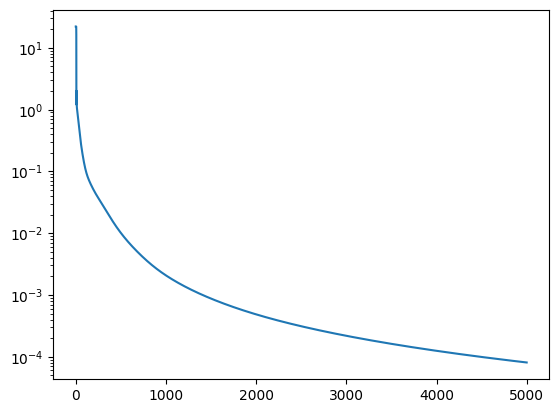

In [17]:
parameters_opti, gradients, cost_list, cost_list2_acc_opti, index_acc, train_accuracy_acc, test_accuracy_acc, ratio, gradient_list_acc  = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 1/estimated_L
, num_iterations = 5000, list_step = False, momentum=0.99)  

plt.plot(index_acc, np.linalg.norm(gradient_list_acc, axis=1))
plt.yscale('log')

w_optimal = parameters_opti['weight'].reshape(-1)
b_optimal = parameters_opti['bias']
cost_optimal = cost_list2_acc_opti[-1]

In [18]:
def generate_dynamic_steps(n):
    t = np.zeros(n)
    t[0] = np.sqrt(2)
    Tn_minus_1 = t[0]
    for i in range(1, n):
        term = Tn_minus_1
        t[i] = (-term + np.sqrt(term**2 + 8 * (term + 1))) / 2
        Tn_minus_1 += t[i]

    return t

In [19]:
chosen_nbr_steps = 100

h_511 = h(chosen_nbr_steps)
dynamic_511 = generate_dynamic_steps(chosen_nbr_steps)

h_511 /= estimated_L
dynamic_511 /= estimated_L

In [20]:
def plot_scatter(x, y, color = 'blue', label = '', prefixe = plt, marker = None):
    if marker == None:
        prefixe.plot(x, y, color, label = label)
    else:
        prefixe.plot(x, y, color, label = label, marker = marker, markersize = 8)

In [21]:
nbr_of_bits_exp_silver_list = np.array([0, 1, 2, 3, -1])
delta_silver_exp_list = np.concatenate((0.5**(nbr_of_bits_exp_silver_list[:-1]+1), [0]))

best_grad_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))
best_training_acc_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))
best_test_acc_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))

for i in range(len(nbr_of_bits_exp_silver_list)):
    best_grad_several_cst, best_training_several_cst, best_test_several_cst = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1.5/estimated_L
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_dynamic, best_training_several_dynamic, best_test_several_dynamic = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = dynamic_511
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_silver, best_training_several_silver, best_test_several_silver = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = h_511
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_FGM, best_training_several_FGM, best_test_several_FGM = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1/estimated_L
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits=nbr_of_bits_exp_silver_list[i], momentum = 0.9)

    best_grad_list[i,0] = best_grad_several_cst
    best_grad_list[i,1] = best_grad_several_dynamic
    best_grad_list[i,2] = best_grad_several_silver
    best_grad_list[i,3] = best_grad_several_FGM

    best_training_acc_list[i,0] = best_training_several_cst
    best_training_acc_list[i,1] = best_training_several_dynamic
    best_training_acc_list[i,2] = best_training_several_silver
    best_training_acc_list[i,3] = best_training_several_FGM

    best_test_acc_list[i,0] = best_test_several_cst
    best_test_acc_list[i,1] = best_test_several_dynamic
    best_test_acc_list[i,2] = best_test_several_silver
    best_test_acc_list[i,3] = best_test_several_FGM

    print(str((i+1)/len(nbr_of_bits_exp_silver_list)*100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


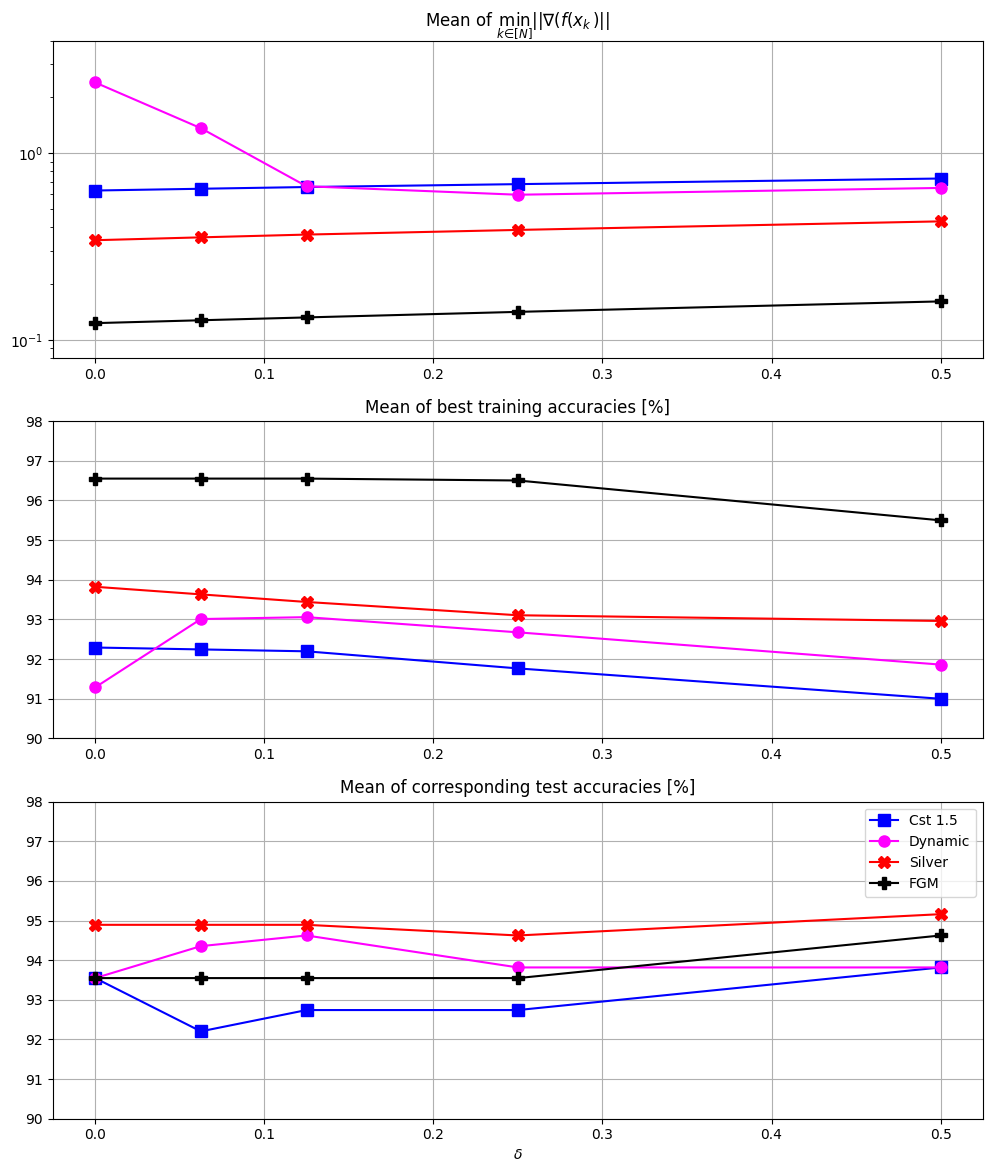

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,14))

plot_scatter(delta_silver_exp_list, best_grad_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax1, marker = 's')
plot_scatter(delta_silver_exp_list, best_grad_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax1, marker = 'o')
plot_scatter(delta_silver_exp_list, best_grad_list[:,2], label = "Silver", color = "red", prefixe=ax1, marker = "X")
plot_scatter(delta_silver_exp_list, best_grad_list[:,3], label = "FGM", color = "black", prefixe=ax1, marker = "P")
ax1.set_title(r"Mean of $\min_{k\in[N]} ||\nabla(f(x_k)||$")
ax1.set_yscale('log')
ax1.set_ylim(bottom = 0.08, top = 4)
ax1.grid()

plot_scatter(delta_silver_exp_list, best_training_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax2, marker = 's')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax2, marker='o')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,2], label = "Silver", color = "red", prefixe=ax2,marker="X")
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,3], label = "FGM", color = "black", prefixe=ax2,marker="P")
ax2.set_title("Mean of best training accuracies [%]")
ax2.set_ylim(bottom = 90, top = 98)
ax2.grid()



plot_scatter(delta_silver_exp_list, best_test_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax3,marker='s')
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax3,marker="o")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,2], label = "Silver", color = "red", prefixe=ax3,marker="X")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,3], label = "FGM", color = "black", prefixe=ax3,marker="P")
ax3.set_title("Mean of corresponding test accuracies [%]")
ax3.set_ylim(bottom = 90, top = 98)
ax3.grid()
ax3.set_xlabel(r'$\delta$')


plt.legend()
plt.savefig("Images/Experiment_hands_several_x0_mantissa.eps", bbox_inches = 'tight')

In [23]:
nbr_of_bits_exp_silver_list = np.array([0, 1, 2, 3, -1])
delta_silver_exp_list = np.concatenate((0.5**(nbr_of_bits_exp_silver_list[:-1]+1), [0]))

best_grad_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))
best_training_acc_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))
best_test_acc_list = np.zeros((len(nbr_of_bits_exp_silver_list), 4))

for i in range(len(nbr_of_bits_exp_silver_list)):
    best_grad_several_cst, best_training_several_cst, best_test_several_cst = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1.5/((1+delta_silver_exp_list[i])*estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_dynamic, best_training_several_dynamic, best_test_several_dynamic = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = dynamic_511/(1+delta_silver_exp_list[i])
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_silver, best_training_several_silver, best_test_several_silver = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = h_511/(1+delta_silver_exp_list[i])
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits=nbr_of_bits_exp_silver_list[i])
    best_grad_several_FGM, best_training_several_FGM, best_test_several_FGM = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1/((1+delta_silver_exp_list[i])*estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits=nbr_of_bits_exp_silver_list[i], momentum = 0.9)

    best_grad_list[i,0] = best_grad_several_cst
    best_grad_list[i,1] = best_grad_several_dynamic
    best_grad_list[i,2] = best_grad_several_silver
    best_grad_list[i,3] = best_grad_several_FGM

    best_training_acc_list[i,0] = best_training_several_cst
    best_training_acc_list[i,1] = best_training_several_dynamic
    best_training_acc_list[i,2] = best_training_several_silver
    best_training_acc_list[i,3] = best_training_several_FGM

    best_test_acc_list[i,0] = best_test_several_cst
    best_test_acc_list[i,1] = best_test_several_dynamic
    best_test_acc_list[i,2] = best_test_several_silver
    best_test_acc_list[i,3] = best_test_several_FGM

    print(str((i+1)/len(nbr_of_bits_exp_silver_list)*100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


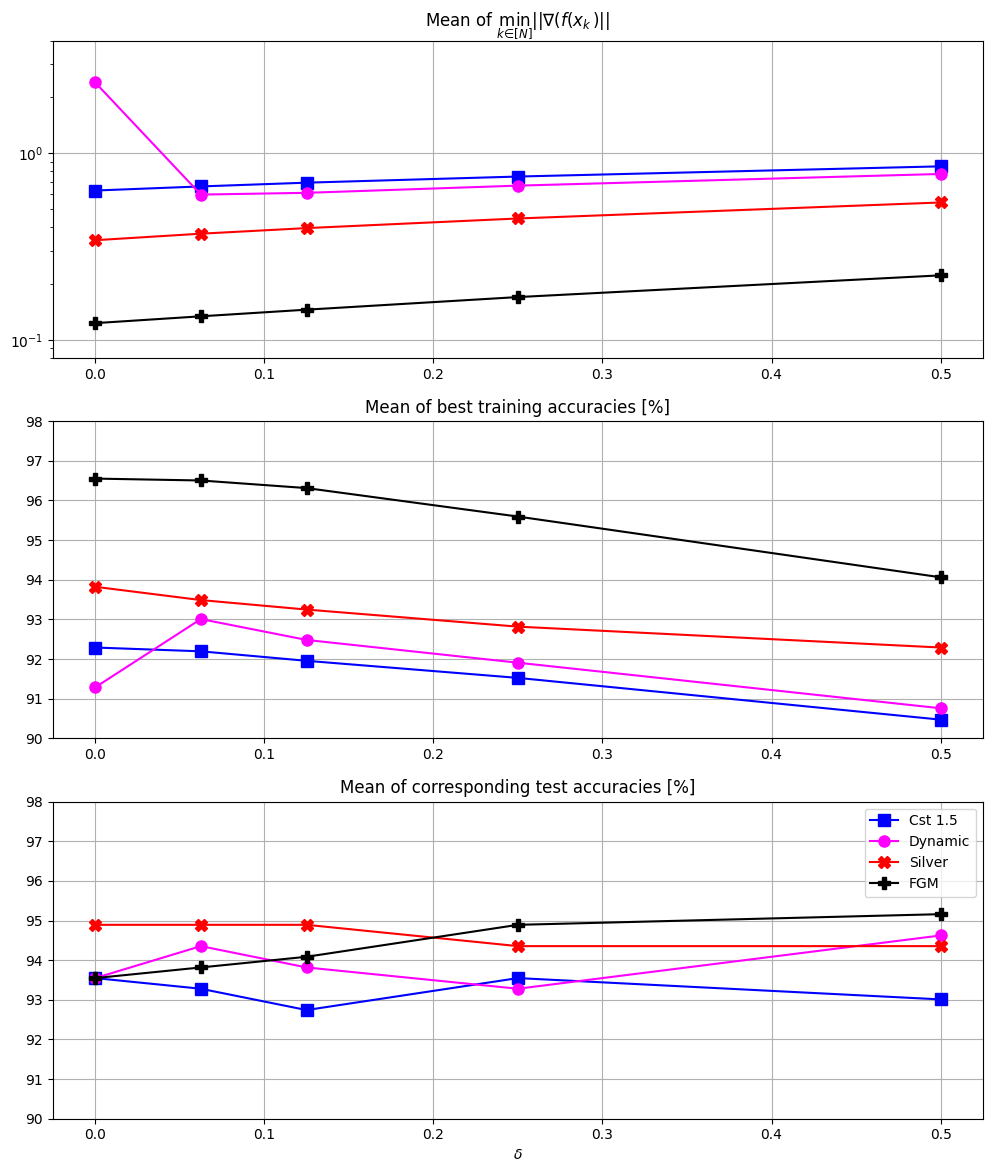

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,14))

plot_scatter(delta_silver_exp_list, best_grad_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax1, marker = 's')
plot_scatter(delta_silver_exp_list, best_grad_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax1, marker = 'o')
plot_scatter(delta_silver_exp_list, best_grad_list[:,2], label = "Silver", color = "red", prefixe=ax1, marker = "X")
plot_scatter(delta_silver_exp_list, best_grad_list[:,3], label = "FGM", color = "black", prefixe=ax1, marker = "P")
ax1.set_title(r"Mean of $\min_{k\in[N]} ||\nabla(f(x_k)||$")
ax1.set_yscale('log')
ax1.set_ylim(bottom = 0.08, top = 4)
ax1.grid()

plot_scatter(delta_silver_exp_list, best_training_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax2, marker = 's')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax2, marker='o')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,2], label = "Silver", color = "red", prefixe=ax2,marker="X")
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,3], label = "FGM", color = "black", prefixe=ax2,marker="P")
ax2.set_title("Mean of best training accuracies [%]")
ax2.set_ylim(bottom = 90, top = 98)
ax2.grid()



plot_scatter(delta_silver_exp_list, best_test_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax3,marker='s')
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax3,marker="o")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,2], label = "Silver", color = "red", prefixe=ax3,marker="X")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,3], label = "FGM", color = "black", prefixe=ax3,marker="P")
ax3.set_title("Mean of corresponding test accuracies [%]")
ax3.set_ylim(bottom = 90, top = 98)
ax3.grid()
ax3.set_xlabel(r'$\delta$')


plt.legend()
plt.savefig("Images/Experiment_hands_several_x0_mantissa_divided.eps", bbox_inches = 'tight')

In [25]:
delta_silver_exp_list = np.arange(0,1,0.1)

best_grad_list = np.zeros((len(delta_silver_exp_list), 4))
best_training_acc_list = np.zeros((len(delta_silver_exp_list), 4))
best_test_acc_list = np.zeros((len(delta_silver_exp_list), 4))

for i in range(len(delta_silver_exp_list)):
    best_grad_several_cst, best_training_several_cst, best_test_several_cst = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1.5/(estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_dynamic, best_training_several_dynamic, best_test_several_dynamic = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = dynamic_511
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_silver, best_training_several_silver, best_test_several_silver = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = h_511
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_FGM, best_training_several_FGM, best_test_several_FGM = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1/(estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits='worst', momentum = 0.9, delta=delta_silver_exp_list[i])

    best_grad_list[i,0] = best_grad_several_cst
    best_grad_list[i,1] = best_grad_several_dynamic
    best_grad_list[i,2] = best_grad_several_silver
    best_grad_list[i,3] = best_grad_several_FGM

    best_training_acc_list[i,0] = best_training_several_cst
    best_training_acc_list[i,1] = best_training_several_dynamic
    best_training_acc_list[i,2] = best_training_several_silver
    best_training_acc_list[i,3] = best_training_several_FGM

    best_test_acc_list[i,0] = best_test_several_cst
    best_test_acc_list[i,1] = best_test_several_dynamic
    best_test_acc_list[i,2] = best_test_several_silver
    best_test_acc_list[i,3] = best_test_several_FGM

    print(str((i+1)/len(delta_silver_exp_list)*100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


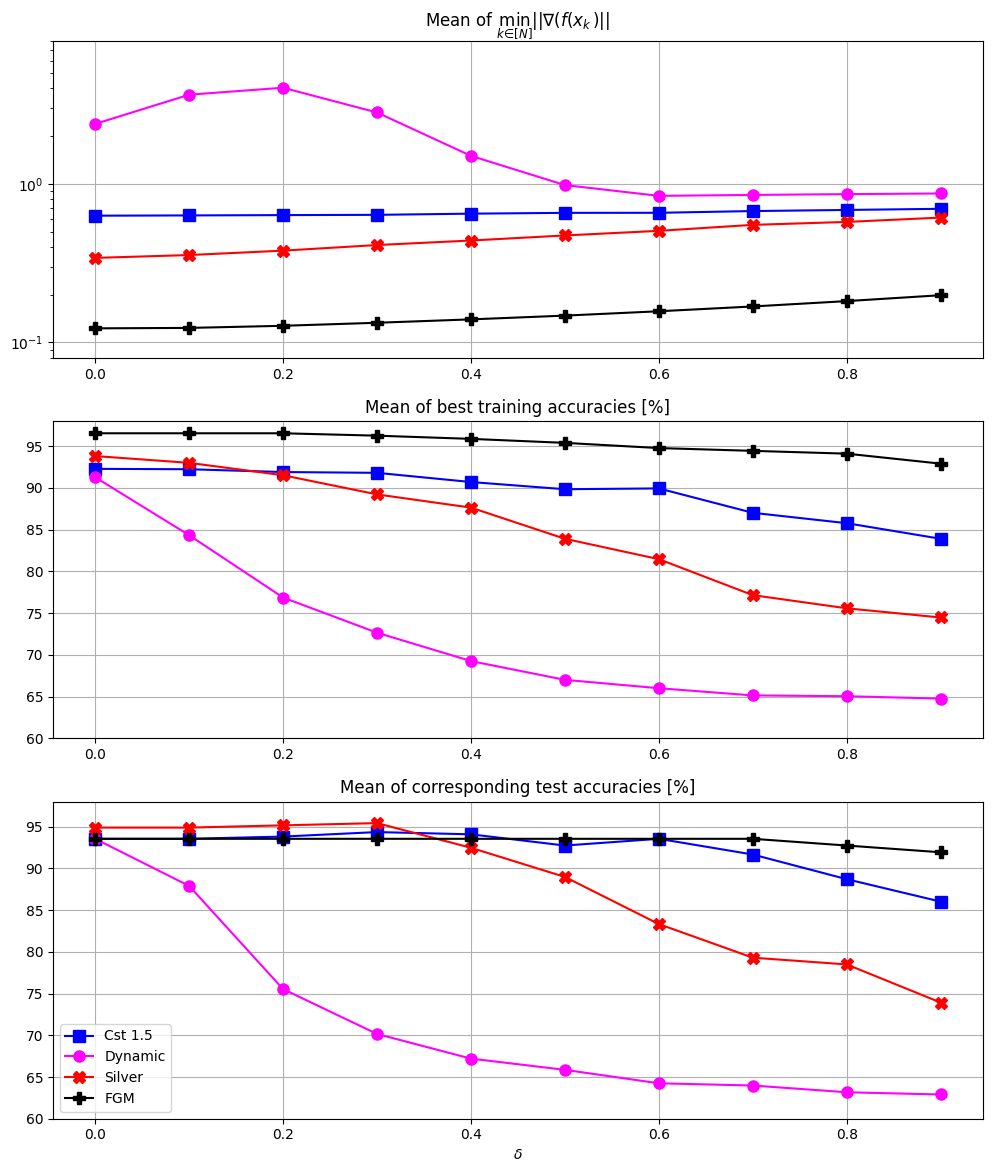

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,14))

plot_scatter(delta_silver_exp_list, best_grad_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax1, marker = 's')
plot_scatter(delta_silver_exp_list, best_grad_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax1, marker = 'o')
plot_scatter(delta_silver_exp_list, best_grad_list[:,2], label = "Silver", color = "red", prefixe=ax1, marker = "X")
plot_scatter(delta_silver_exp_list, best_grad_list[:,3], label = "FGM", color = "black", prefixe=ax1, marker = "P")
ax1.set_title(r"Mean of $\min_{k\in[N]} ||\nabla(f(x_k)||$")
ax1.set_yscale('log')
ax1.set_ylim(bottom = 0.08, top = 8)
ax1.grid()

plot_scatter(delta_silver_exp_list, best_training_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax2, marker = 's')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax2, marker='o')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,2], label = "Silver", color = "red", prefixe=ax2,marker="X")
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,3], label = "FGM", color = "black", prefixe=ax2,marker="P")
ax2.set_title("Mean of best training accuracies [%]")
ax2.set_ylim(bottom = 60, top = 98)
ax2.grid()



plot_scatter(delta_silver_exp_list, best_test_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax3,marker='s')
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax3,marker="o")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,2], label = "Silver", color = "red", prefixe=ax3,marker="X")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,3], label = "FGM", color = "black", prefixe=ax3,marker="P")
ax3.set_title("Mean of corresponding test accuracies [%]")
ax3.set_ylim(bottom = 60, top = 98)
ax3.grid()
ax3.set_xlabel(r'$\delta$')

plt.legend()
plt.savefig("Images/Experiment_hands_several_x0_worst.eps", bbox_inches = 'tight')

In [27]:
delta_silver_exp_list = np.arange(0,1,0.1)

best_grad_list = np.zeros((len(delta_silver_exp_list), 4))
best_training_acc_list = np.zeros((len(delta_silver_exp_list), 4))
best_test_acc_list = np.zeros((len(delta_silver_exp_list), 4))

for i in range(len(delta_silver_exp_list)):
    best_grad_several_cst, best_training_several_cst, best_test_several_cst = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1.5/((1+delta_silver_exp_list[i])*estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_dynamic, best_training_several_dynamic, best_test_several_dynamic = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = dynamic_511/(1+delta_silver_exp_list[i])
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_silver, best_training_several_silver, best_test_several_silver = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = h_511/(1+delta_silver_exp_list[i])
    , num_iterations = chosen_nbr_steps, list_step = True, number_of_bits='worst', delta=delta_silver_exp_list[i])
    best_grad_several_FGM, best_training_several_FGM, best_test_several_FGM = multiple_x0_logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 1/((1+delta_silver_exp_list[i])*estimated_L)
    , num_iterations = chosen_nbr_steps, list_step = False, number_of_bits='worst', momentum = 0.9, delta=delta_silver_exp_list[i])

    best_grad_list[i,0] = best_grad_several_cst
    best_grad_list[i,1] = best_grad_several_dynamic
    best_grad_list[i,2] = best_grad_several_silver
    best_grad_list[i,3] = best_grad_several_FGM

    best_training_acc_list[i,0] = best_training_several_cst
    best_training_acc_list[i,1] = best_training_several_dynamic
    best_training_acc_list[i,2] = best_training_several_silver
    best_training_acc_list[i,3] = best_training_several_FGM

    best_test_acc_list[i,0] = best_test_several_cst
    best_test_acc_list[i,1] = best_test_several_dynamic
    best_test_acc_list[i,2] = best_test_several_silver
    best_test_acc_list[i,3] = best_test_several_FGM

    print(str((i+1)/len(delta_silver_exp_list)*100) + "%",  end='\r')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


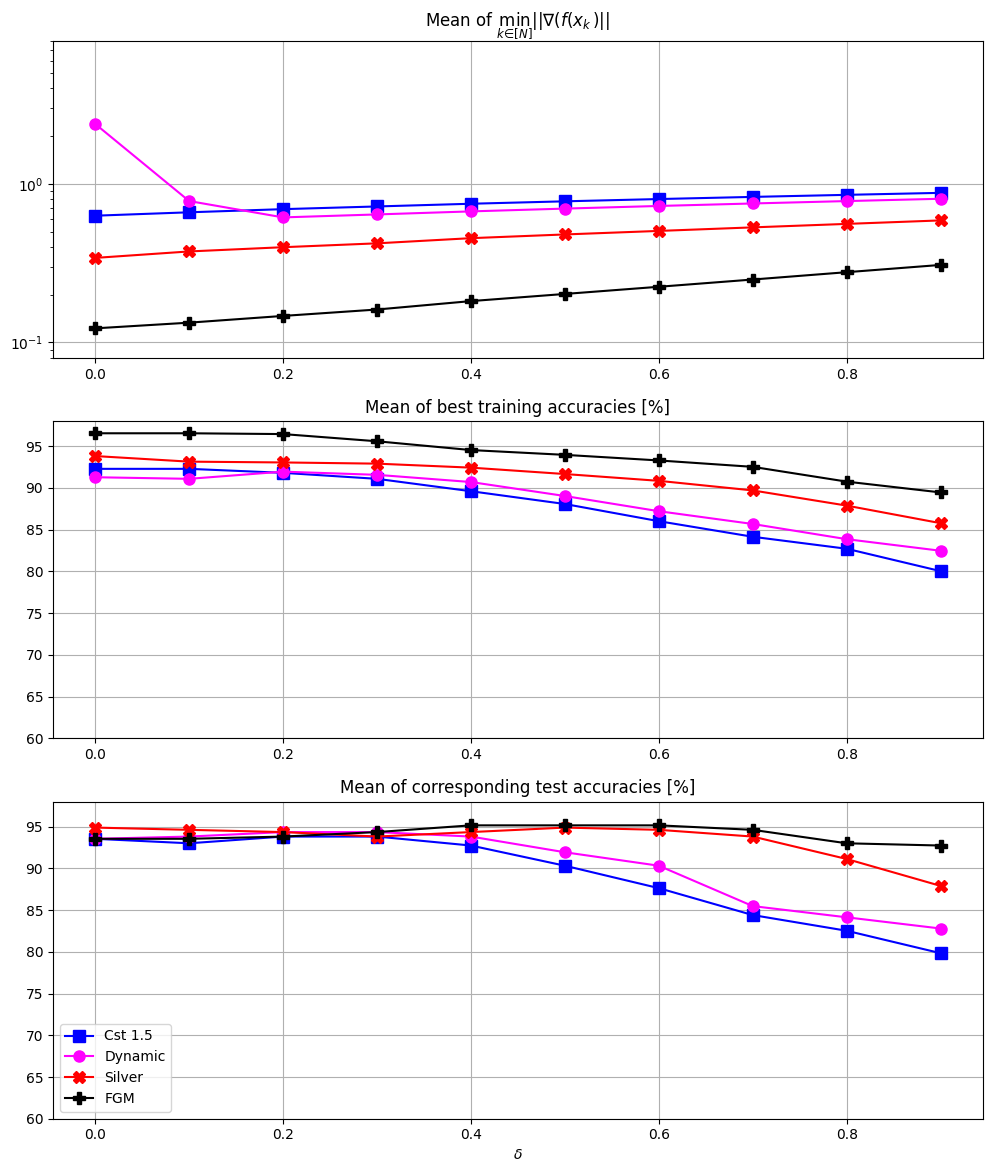

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,14))

plot_scatter(delta_silver_exp_list, best_grad_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax1, marker = 's')
plot_scatter(delta_silver_exp_list, best_grad_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax1, marker = 'o')
plot_scatter(delta_silver_exp_list, best_grad_list[:,2], label = "Silver", color = "red", prefixe=ax1, marker = "X")
plot_scatter(delta_silver_exp_list, best_grad_list[:,3], label = "FGM", color = "black", prefixe=ax1, marker = "P")
ax1.set_title(r"Mean of $\min_{k\in[N]} ||\nabla(f(x_k)||$")
ax1.set_yscale('log')
ax1.set_ylim(bottom = 0.08, top = 8)
ax1.grid()

plot_scatter(delta_silver_exp_list, best_training_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax2, marker = 's')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax2, marker='o')
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,2], label = "Silver", color = "red", prefixe=ax2,marker="X")
plot_scatter(delta_silver_exp_list, best_training_acc_list[:,3], label = "FGM", color = "black", prefixe=ax2,marker="P")
ax2.set_title("Mean of best training accuracies [%]")
ax2.set_ylim(bottom = 60, top = 98)
ax2.grid()



plot_scatter(delta_silver_exp_list, best_test_acc_list[:,0], label = "Cst 1.5", color = "blue", prefixe=ax3,marker='s')
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,1], label = "Dynamic", color = "magenta", prefixe=ax3,marker="o")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,2], label = "Silver", color = "red", prefixe=ax3,marker="X")
plot_scatter(delta_silver_exp_list, best_test_acc_list[:,3], label = "FGM", color = "black", prefixe=ax3,marker="P")
ax3.set_title("Mean of corresponding test accuracies [%]")
ax3.set_ylim(bottom = 60, top = 98)
ax3.grid()
ax3.set_xlabel(r'$\delta$')

plt.legend()
plt.savefig("Images/Experiment_hands_several_x0_worst_divided.eps", bbox_inches = 'tight')